In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

SUPPORT_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT']
OPPOSE_TAGS = ['DEFINITELY OPPOSE', 'SOMEWHAT OPPOSE']
APPROVE_TAGS = ['APPROVED', 'APPROVED WITH MINOR CHANGES']


In [2]:
df = dt.get_supplemental_docs()

No proper response found for 2018-06-14, doc_id 1, pages 2-2


In [3]:
idx = df['support_or_oppose'].isin(SUPPORT_TAGS + OPPOSE_TAGS)
idx_support = df['support_or_oppose'].isin(SUPPORT_TAGS)
idx_oppose = df['support_or_oppose'].isin(OPPOSE_TAGS)

In [4]:
# Keep only documents that either support or oppose
df2 = df.loc[idx].reset_index(drop=True)

In [5]:
minutes_df = dt.get_minutes()

No data found for 2021-01-14
No data found for 2022-03-17
No data found for 2022-10-13


In [6]:
df3 = minutes_df.copy()

In [7]:
df3['n_support'] = 0
df3['n_oppose'] = 0
for idx, irow in df3.iterrows():
    date = irow['date']
    item_no = irow['item_no']
    for jdx, jrow in df2.loc[df2['date']==date].iterrows():
        referenced_items = [s.strip() for s in jrow['referenced_items'].split(',')]
        support_or_oppose = jrow['support_or_oppose']
        if item_no in referenced_items:
            df3.loc[idx, 'n_support'] += 1*(support_or_oppose in SUPPORT_TAGS)
            df3.loc[idx, 'n_oppose'] += 1*(support_or_oppose in OPPOSE_TAGS)

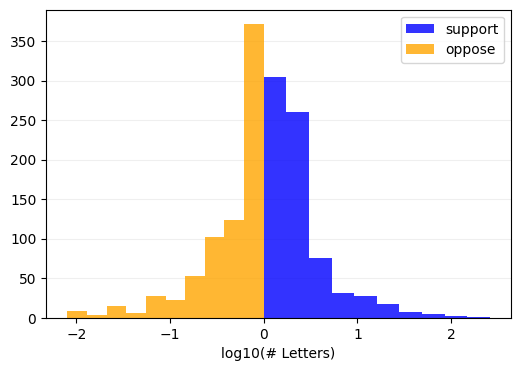

In [8]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(df3['n_support']+1), alpha=0.8, color='blue', label='support')
plt.hist(-np.log10(df3['n_oppose']+1), alpha=0.8, color='orange', label='oppose')
plt.xlabel('log10(# Letters)')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.gca().set_axisbelow(True)
plt.show()

In [9]:
df3['project_result'].value_counts()

project_result
APPROVED                                  333
APPROVED WITH MINOR CHANGES               269
DELIBERATIONS CONTINUED TO FUTURE DATE    112
DENIED                                     11
APPROVED WITH MAJOR CHANGES                 7
Name: count, dtype: int64

In [10]:
df3['log2_support'] = np.log(df3['n_support']+1)/np.log(2)
df3['log2_oppose'] = np.log(df3['n_oppose']+1)/np.log(2)

approve_tags = ['APPROVED', 'APPROVED WITH MINOR CHANGES']
predictors = ['log2_support', 'log2_oppose']

y = df3['project_result'].isin(approve_tags)
X = sm.add_constant(df3[predictors])

model = sm.Logit(y, X).fit()

sg = Stargazer([model])

HTML(sg.render_html())

Optimization terminated successfully.
         Current function value: 0.453977
         Iterations 6


In [11]:
params = model.params
np.exp(params)

const           4.961529
log2_support    1.321559
log2_oppose     0.736860
dtype: float64